# Dependencies and imports

In [1]:
import json

import numpy as np
import pandas as pd

import matplotlib
import matplotlib as mpl
from matplotlib import pyplot as plt

In [2]:
TEXTS_PREFIXES = ['original', 'reviewer1', 'reviewer2', 'gpt4']
TEXTS_NAMES = ['Original', 'Human 1', 'Human 2', 'GPT-4']

DOCUMENT_REGION_MAP = {
    '99bdc9fdd8097f067f77cb220074b1b5': 'Basilicata',
    '07108e7d68b7e897ed6a800be9802105': 'Calabria',
    '2f4c39c9fb796e5066ac28770c5724d6': 'Campania',
    '3e0abd25f3bcf417e9e0a8b74e158ef5': 'Lombardia',
    '396505aaf67c46b9ec1a6818d8fb9af6': 'Lazio',
    '6d52bcc84ee3fa9bfec74bb009537bd2': 'Molise',
    '70da2ae575436d19518deae1ff2125b0': 'Toscana',
    'aae5c6f0c213946d265cb98c08106c0b': 'Veneto',
}

In [3]:
plt.rcParams["figure.figsize"] = (15,5)

plt.rcParams["axes.facecolor"] = (1, 1, 1, 0)
plt.rcParams["axes.edgecolor"] = (1, 1, 1, 1)
plt.rcParams["axes.linewidth"] = 0.8
plt.rcParams["axes.grid"] = False
plt.rcParams["axes.grid.axis"] = 'both'
plt.rcParams["axes.grid.which"] = 'major'

plt.rcParams["legend.fancybox"] = True
plt.rcParams["legend.framealpha"] = 0.8
plt.rcParams["legend.facecolor"]  = (1, 1, 1, 1)

# Utils

In [4]:
def merge_sets(sets):
  merged = set()
  for s in sets:
    merged = merged.union(s)
  return merged

In [5]:
def parse_heatmap_data(_dfs_map, _reviewers, _index_to_collect, _f):
  data = []
  for doc in DOCUMENT_REGION_MAP.keys():
    row = []
    for reviewer in _reviewers:
      if _index_to_collect == 'tokens':
        rev_json = jsons_maps[reviewer]
        row.append(_f([set(j[f'{reviewer}_{_index_to_collect}']) for j in rev_json if j['document'] == doc]))
      else:
        rev_df = _dfs_map[reviewer]
        doc_df = rev_df[rev_df['document'] == doc]
        row.append(_f(doc_df[f'{reviewer}_{_index_to_collect}']))
    data.append(row)
  return np.asarray(data)


def heatmap(data, row_labels, col_labels, ax=None,
            vmin=0, vmax=0, valfmt="{x:.2f}",
            textcolors=("black", "black"),
            threshold=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    if vmax == 0:
      vmax = np.nanmax(data)

    # Plot the heatmap
    im = ax.imshow(data, vmin=vmin, vmax=vmax, **kwargs)

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    ax.grid(which="major", color="w", linestyle='-', linewidth=0)


    ## ANNOTATION

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if not np.isnan(data[i, j]):
              kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
              text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
              texts.append(text)

    return im


def colorbar(data, cmap, ax, label, vmin=0, vmax=0):
  if vmax == 0:
    vmax = np.nanmax(data)

  plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax), cmap=cmap),
               ax=ax,
               shrink=0.8,
               location='bottom',
               orientation='horizontal',
               label=label)


# Colors

In [6]:
colors = [(1, 0, 0), (1, 1, 0), (0, 1, 0)]  # Green to Red
mpl.colormaps.unregister('high_to_low_cmap')
mpl.colormaps.register(matplotlib.colors.LinearSegmentedColormap.from_list('high_to_low_cmap', colors, N=256))

In [7]:
colors = [(0, 1, 0), (1, 1, 0), (1, 0, 0)]  # Red to Green
mpl.colormaps.unregister('low_to_high_cmap')
mpl.colormaps.register(matplotlib.colors.LinearSegmentedColormap.from_list('low_to_high_cmap', colors, N=256))

In [8]:
vdb_colors = [
  (1, 0, 0),
  (0.66, 0.33, 0),
  (0.33, 0.66, 0),
  (0, 1, 0)
]
mpl.colormaps.unregister('vdb_cmap')
mpl.colormaps.register(matplotlib.colors.LinearSegmentedColormap.from_list('vdb_cmap', vdb_colors, N=5))

In [9]:
gulpease_index_colors = [
  (1, 0, 0),
  (1, 0, 0),
  (1, 0, 0),
  (1, 0, 0),
  (0.66, 0.33, 0),
  (0.66, 0.33, 0),
  (0.33, 0.66, 0),
  (0.33, 0.66, 0),
  (0, 1, 0),
  (0, 1, 0)
]
mpl.colormaps.unregister('gulpease_cmap')
mpl.colormaps.register(matplotlib.colors.LinearSegmentedColormap.from_list('gulpease_cmap', gulpease_index_colors, N=10))

In [10]:
flesch_reading_ease_colors = [
  (1, 0, 0),
  (1, 0, 0),
  (1, 0, 0),
  (0.75, 0.15, 0),
  (0.75, 0.15, 0),
  (0.60, 0.30, 0),
  (0.45, 0.45, 0),
  (0.30, 0.60, 0),
  (0.15, 0.75, 0),
  (0, 1, 0),
]
mpl.colormaps.unregister('flesch_cmap')
mpl.colormaps.register(matplotlib.colors.LinearSegmentedColormap.from_list('flesch_cmap', flesch_reading_ease_colors, N=10))

# Load Data

In [11]:
dfs_maps = {
  'original': pd.read_csv(f"./corpora_with_metrics/original.csv", encoding='utf-8'),
  'reviewer1': pd.read_csv(f"./corpora_with_metrics/reviewer1.csv", encoding='utf-8'),
  'reviewer2': pd.read_csv(f"./corpora_with_metrics/reviewer2.csv", encoding='utf-8'),
  'gpt4': pd.read_csv(f"./corpora_with_metrics/gpt4.csv", encoding='utf-8'),
}
jsons_maps = {
  'original': json.load(open(f"./corpora_with_metrics/original.json", 'r')),
  'reviewer1': json.load(open(f"./corpora_with_metrics/reviewer1.json", 'r')),
  'reviewer2': json.load(open(f"./corpora_with_metrics/reviewer2.json", 'r')),
  'gpt4': json.load(open(f"./corpora_with_metrics/gpt4.json", 'r')),
}

# Basic

In [12]:
tokens_heat_data = parse_heatmap_data(dfs_maps, TEXTS_PREFIXES, 'n_tokens', lambda x:  x.sum())
chars_heat_data = parse_heatmap_data(dfs_maps, TEXTS_PREFIXES, 'n_chars', lambda x:  x.sum() / 1000)
words_heat_data = parse_heatmap_data(dfs_maps, TEXTS_PREFIXES, 'tokens', lambda x:  len(merge_sets(x)))
sentences_heat_data = parse_heatmap_data(dfs_maps, TEXTS_PREFIXES, 'n_sentences', lambda x:  x.sum())

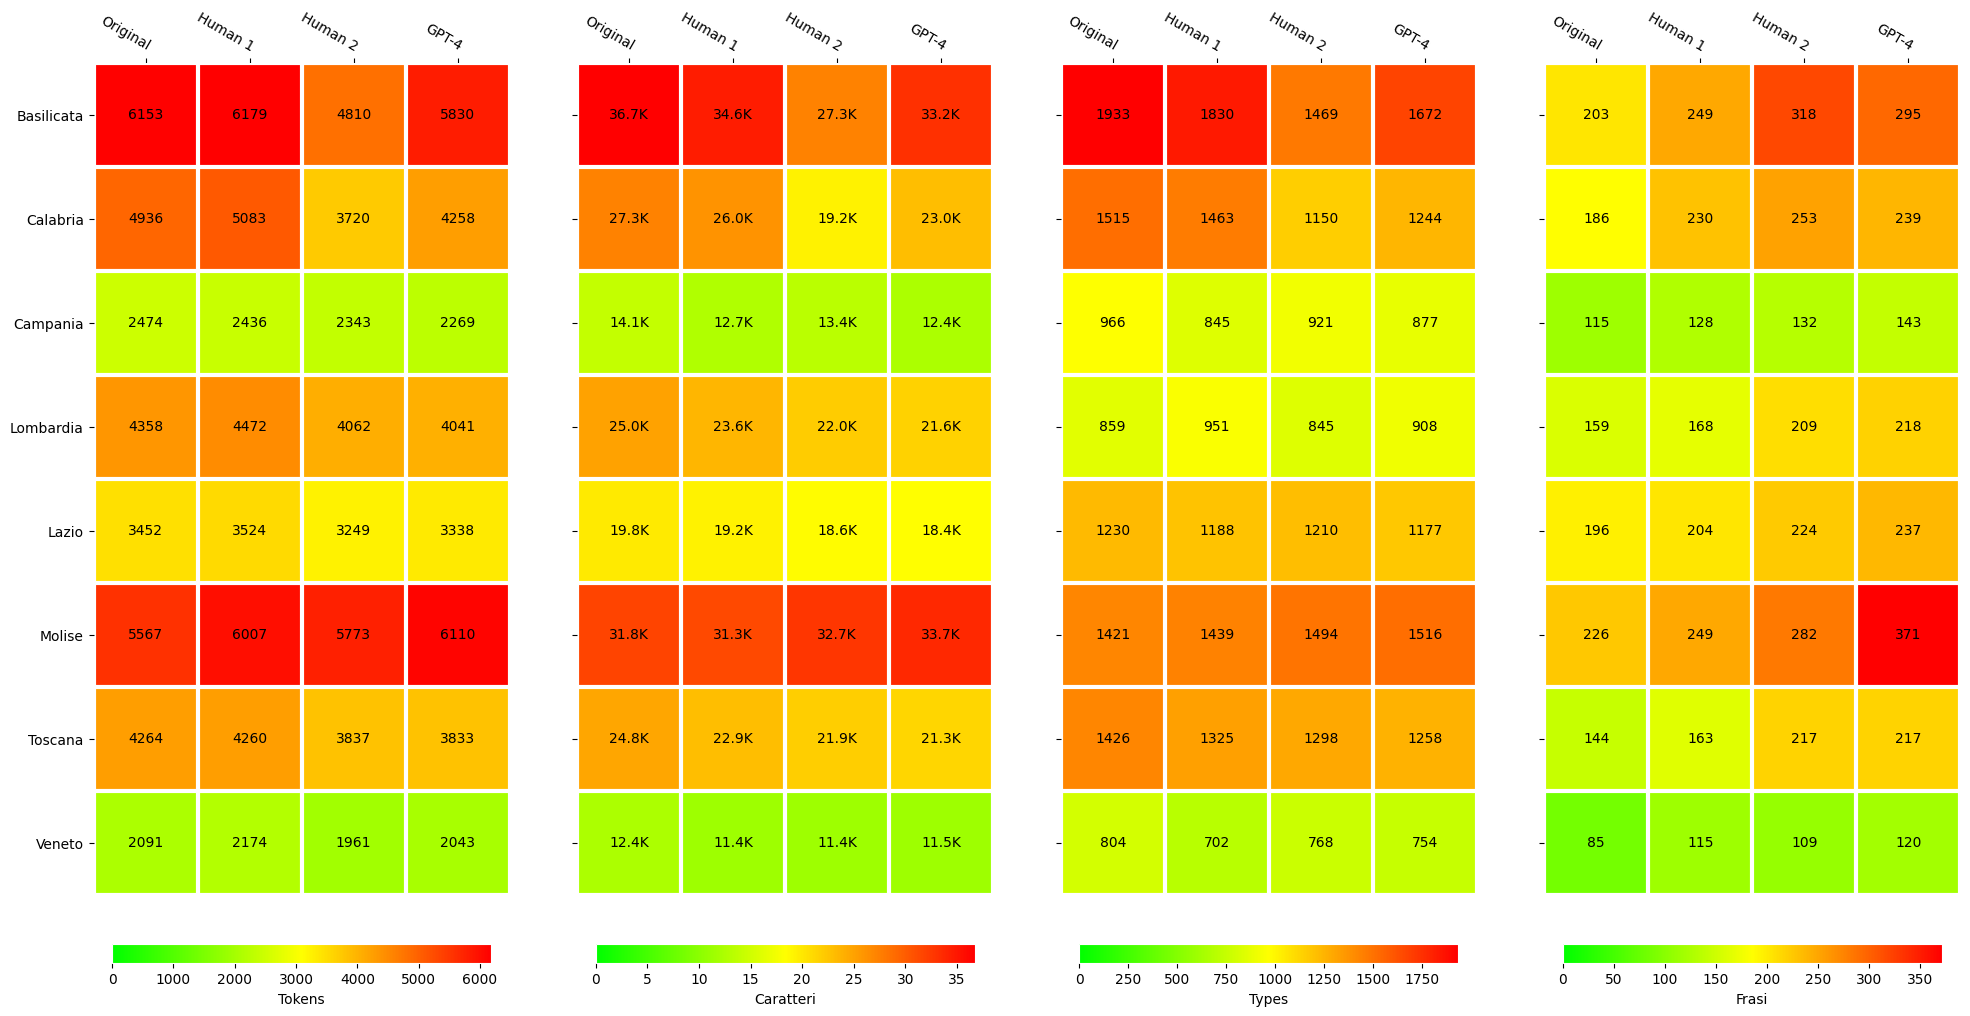

In [13]:
fig, axs = plt.subplots(1, 4, sharex='col', figsize=(20, 10), constrained_layout=True)

heatmap(tokens_heat_data, DOCUMENT_REGION_MAP.values(), TEXTS_NAMES, axs[0], cmap="low_to_high_cmap", valfmt="{x:.0f}")
colorbar(tokens_heat_data, "low_to_high_cmap", ax=axs[0], label="Tokens")

heatmap(chars_heat_data, [], TEXTS_NAMES, axs[1], cmap="low_to_high_cmap", valfmt="{x:.1f}K")
colorbar(chars_heat_data, "low_to_high_cmap", ax=axs[1], label="Caratteri")

heatmap(words_heat_data, [], TEXTS_NAMES, axs[2], cmap="low_to_high_cmap",  valfmt="{x:.0f}")
colorbar(words_heat_data, "low_to_high_cmap", ax=axs[2], label="Types")

heatmap(sentences_heat_data, [], TEXTS_NAMES, axs[3], cmap="low_to_high_cmap", valfmt="{x:.0f}")
colorbar(sentences_heat_data, "low_to_high_cmap", ax=axs[3], label="Frasi")

plt.show()

# Pos

In [14]:
nouns_heat_data = parse_heatmap_data(dfs_maps, TEXTS_PREFIXES, 'n_nouns', lambda x:  x.sum())
verbs_heat_data = parse_heatmap_data(dfs_maps, TEXTS_PREFIXES, 'n_verbs', lambda x:  x.sum())
adjectives_heat_data = parse_heatmap_data(dfs_maps, TEXTS_PREFIXES, 'n_adjectives', lambda x:  x.sum())
pronouns_heat_data = parse_heatmap_data(dfs_maps, TEXTS_PREFIXES, 'n_pronouns', lambda x:  x.sum())
articles_heat_data = parse_heatmap_data(dfs_maps, TEXTS_PREFIXES, 'n_articles', lambda x:  x.sum())
adverbs_heat_data = parse_heatmap_data(dfs_maps, TEXTS_PREFIXES, 'n_adverbs', lambda x:  x.sum())
prepositions_heat_data = parse_heatmap_data(dfs_maps, TEXTS_PREFIXES, 'n_prepositions', lambda x:  x.sum())
conjunctions_heat_data = parse_heatmap_data(dfs_maps, TEXTS_PREFIXES, 'n_coordinating_conjunctions', lambda x:  x.sum()) + parse_heatmap_data(dfs_maps, TEXTS_PREFIXES, 'n_subordinating_conjunctions', lambda x:  x.sum())

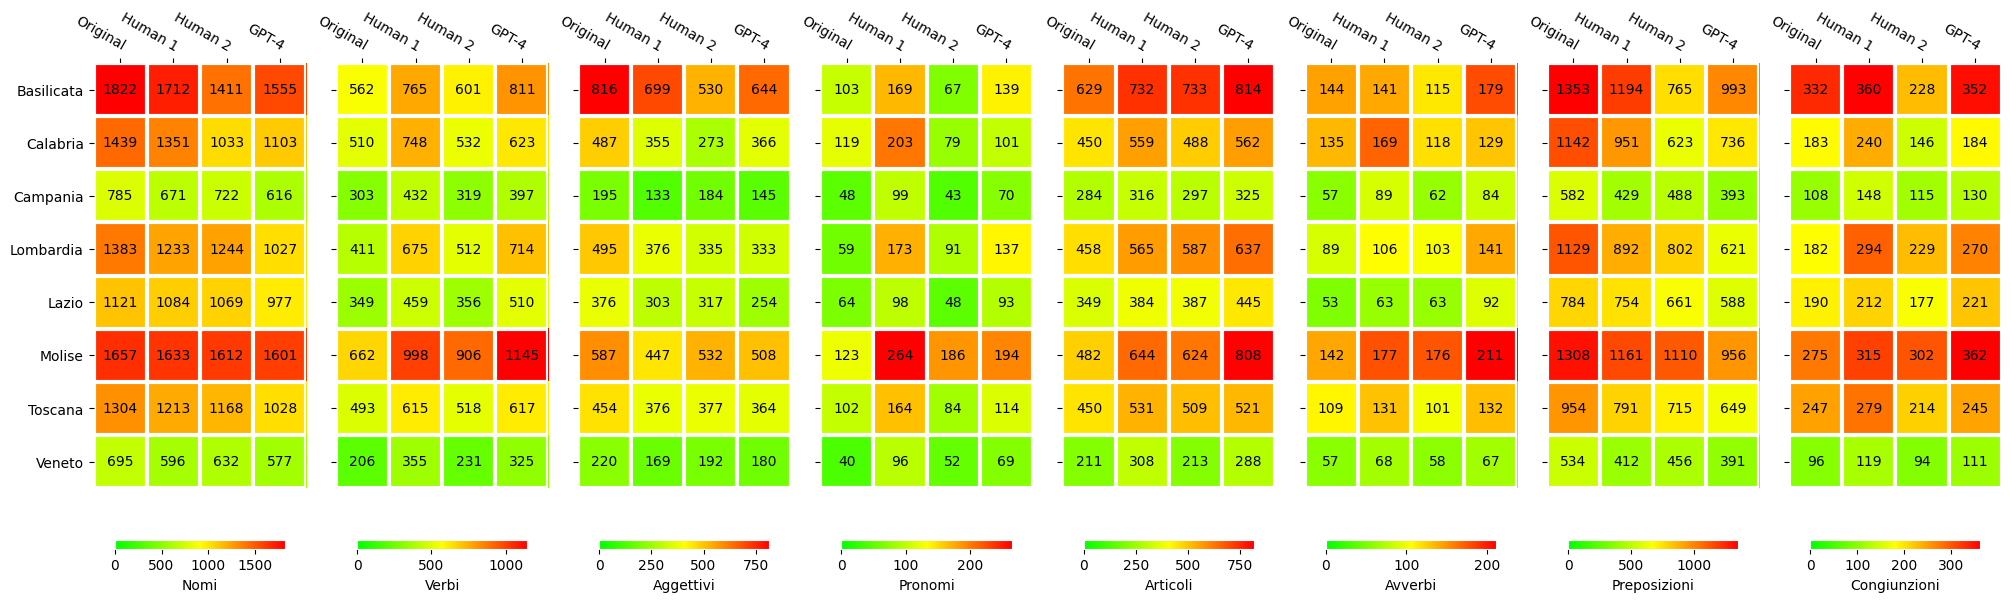

In [15]:
fig, axs = plt.subplots(1, 8, sharex='col', figsize=(20, 10), constrained_layout=True)

heatmap(nouns_heat_data, DOCUMENT_REGION_MAP.values(), TEXTS_NAMES, axs[0], cmap="low_to_high_cmap", valfmt="{x:.0f}")
colorbar(nouns_heat_data, "low_to_high_cmap", ax=axs[0], label="Nomi")

heatmap(verbs_heat_data, [], TEXTS_NAMES, axs[1], cmap="low_to_high_cmap", valfmt="{x:.0f}")
colorbar(verbs_heat_data, "low_to_high_cmap", ax=axs[1], label="Verbi")

heatmap(adjectives_heat_data, [], TEXTS_NAMES, axs[2], cmap="low_to_high_cmap",  valfmt="{x:.0f}")
colorbar(adjectives_heat_data, "low_to_high_cmap", ax=axs[2], label="Aggettivi")

heatmap(pronouns_heat_data, [], TEXTS_NAMES, axs[3], cmap="low_to_high_cmap", valfmt="{x:.0f}")
colorbar(pronouns_heat_data, "low_to_high_cmap", ax=axs[3], label="Pronomi")

heatmap(articles_heat_data, [], TEXTS_NAMES, axs[4], cmap="low_to_high_cmap", valfmt="{x:.0f}")
colorbar(articles_heat_data, "low_to_high_cmap", ax=axs[4], label="Articoli")

heatmap(adverbs_heat_data, [], TEXTS_NAMES, axs[5], cmap="low_to_high_cmap", valfmt="{x:.0f}")
colorbar(adverbs_heat_data, "low_to_high_cmap", ax=axs[5], label="Avverbi")

heatmap(prepositions_heat_data, [], TEXTS_NAMES, axs[6], cmap="low_to_high_cmap", valfmt="{x:.0f}")
colorbar(prepositions_heat_data, "low_to_high_cmap", ax=axs[6], label="Preposizioni")

heatmap(conjunctions_heat_data, [], TEXTS_NAMES, axs[7], cmap="low_to_high_cmap", valfmt="{x:.0f}")
colorbar(conjunctions_heat_data, "low_to_high_cmap", ax=axs[7], label="Congiunzioni")

plt.show()

# Verbs

In [16]:
active_heat_data = parse_heatmap_data(dfs_maps, TEXTS_PREFIXES, 'n_active_verbs', lambda x:  x.sum())
passive_heat_data = parse_heatmap_data(dfs_maps, TEXTS_PREFIXES, 'n_passive_verbs', lambda x:  x.sum())

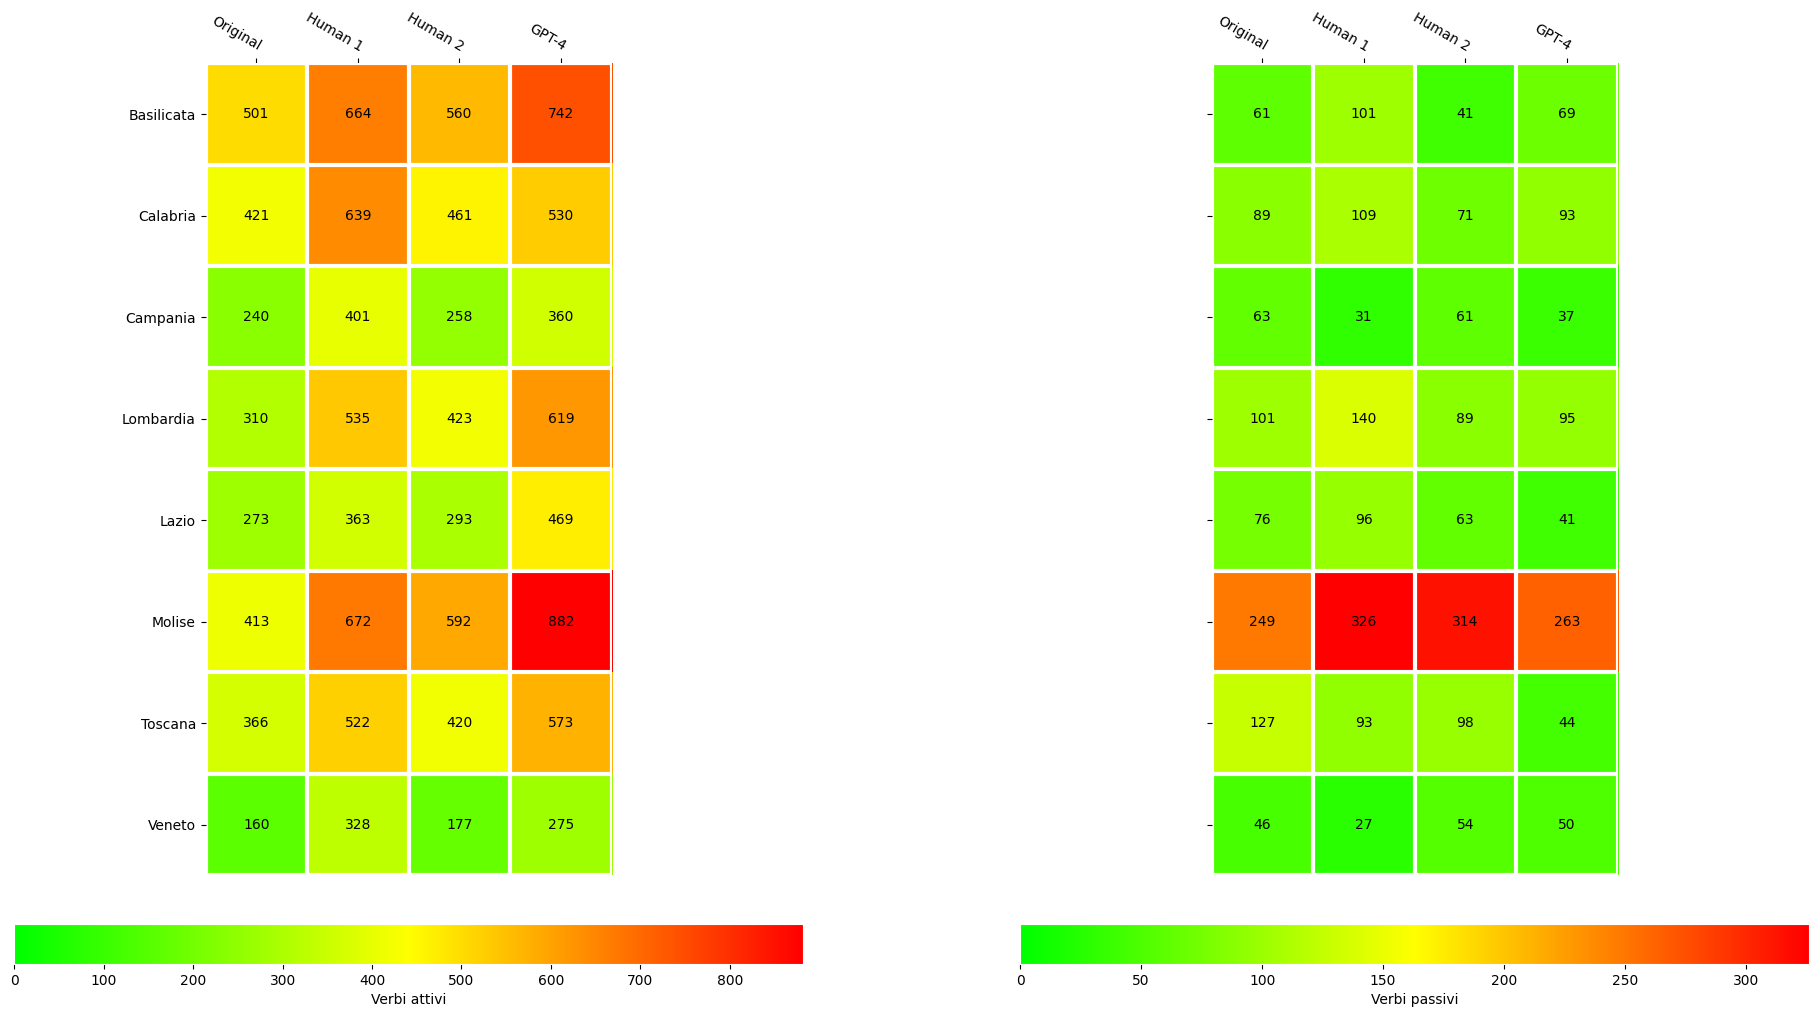

In [17]:
fig, axs = plt.subplots(1, 2, sharex='col', figsize=(20, 10), constrained_layout=True)

heatmap(active_heat_data, DOCUMENT_REGION_MAP.values(), TEXTS_NAMES, axs[0], cmap="low_to_high_cmap", valfmt="{x:.0f}")
colorbar(active_heat_data, "low_to_high_cmap", ax=axs[0], label="Verbi attivi")

heatmap(passive_heat_data, [], TEXTS_NAMES, axs[1], cmap="low_to_high_cmap", valfmt="{x:.0f}")
colorbar(passive_heat_data, "low_to_high_cmap", ax=axs[1], label="Verbi passivi")

plt.show()

# Vdb

In [18]:
vdb_heat_data = parse_heatmap_data(dfs_maps, TEXTS_PREFIXES, 'n_vdb', lambda x:  x.mean())
vdb_fo_heat_data = parse_heatmap_data(dfs_maps, TEXTS_PREFIXES, 'n_vdb_fo', lambda x:  x.mean())
vdb_au_heat_data = parse_heatmap_data(dfs_maps, TEXTS_PREFIXES, 'n_vdb_au', lambda x:  x.mean())
vdb_ad_heat_data = parse_heatmap_data(dfs_maps, TEXTS_PREFIXES, 'n_vdb_ad', lambda x:  x.mean())

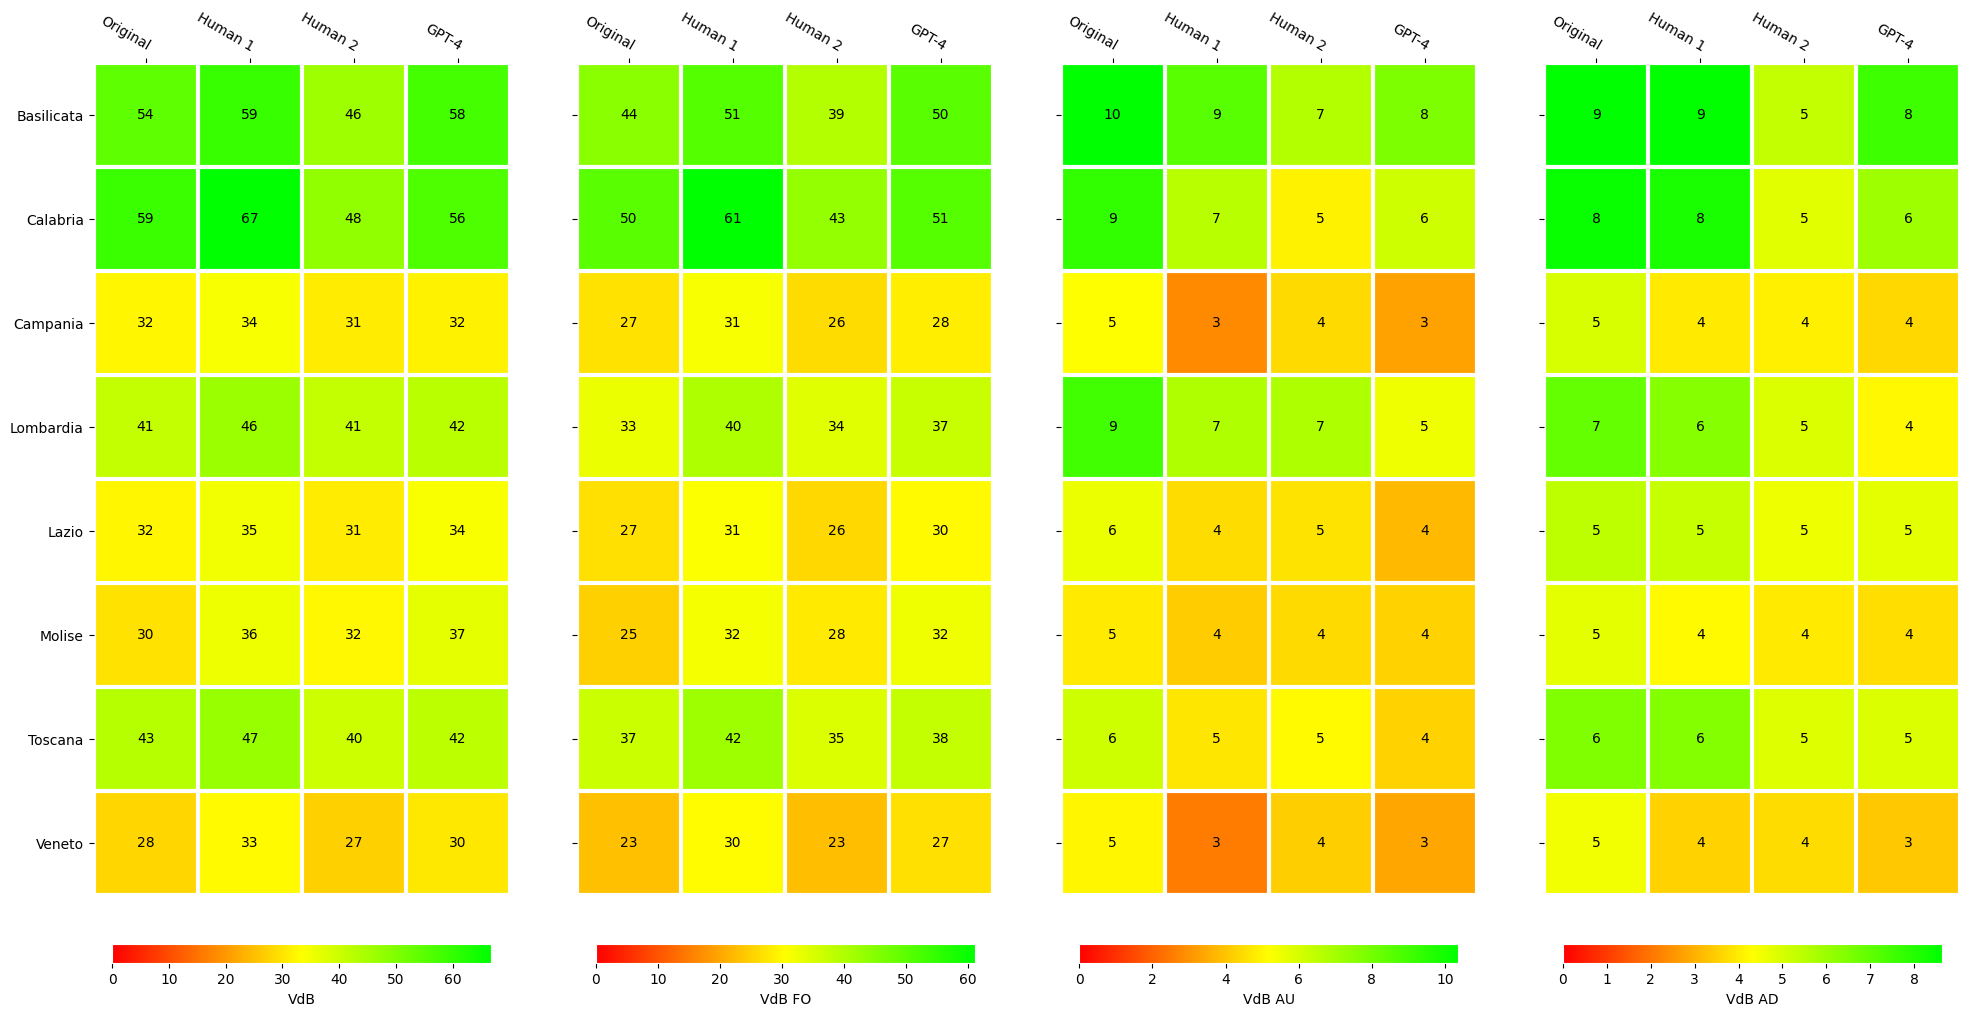

In [19]:
fig, axs = plt.subplots(1, 4, sharex='col', figsize=(20, 10), constrained_layout=True)

heatmap(vdb_heat_data, DOCUMENT_REGION_MAP.values(), TEXTS_NAMES, axs[0], cmap="high_to_low_cmap", valfmt="{x:.0f}")
colorbar(vdb_heat_data, "high_to_low_cmap", ax=axs[0], label="VdB")

heatmap(vdb_fo_heat_data, [], TEXTS_NAMES, axs[1], cmap="high_to_low_cmap", valfmt="{x:.0f}")
colorbar(vdb_fo_heat_data, "high_to_low_cmap", ax=axs[1], label="VdB FO")

heatmap(vdb_au_heat_data, [], TEXTS_NAMES, axs[2], cmap="high_to_low_cmap",  valfmt="{x:.0f}")
colorbar(vdb_au_heat_data, "high_to_low_cmap", ax=axs[2], label="VdB AU")

heatmap(vdb_ad_heat_data, [], TEXTS_NAMES, axs[3], cmap="high_to_low_cmap", valfmt="{x:.0f}")
colorbar(vdb_ad_heat_data, "high_to_low_cmap", ax=axs[3], label="VdB AD")

plt.show()

# Readability

In [20]:
gulpease_heat_data = parse_heatmap_data(dfs_maps, TEXTS_PREFIXES, 'gulpease', lambda x:  x.mean())
flesch_vacca_heat_data = parse_heatmap_data(dfs_maps, TEXTS_PREFIXES, 'flesch_vacca', lambda x:  x.mean())

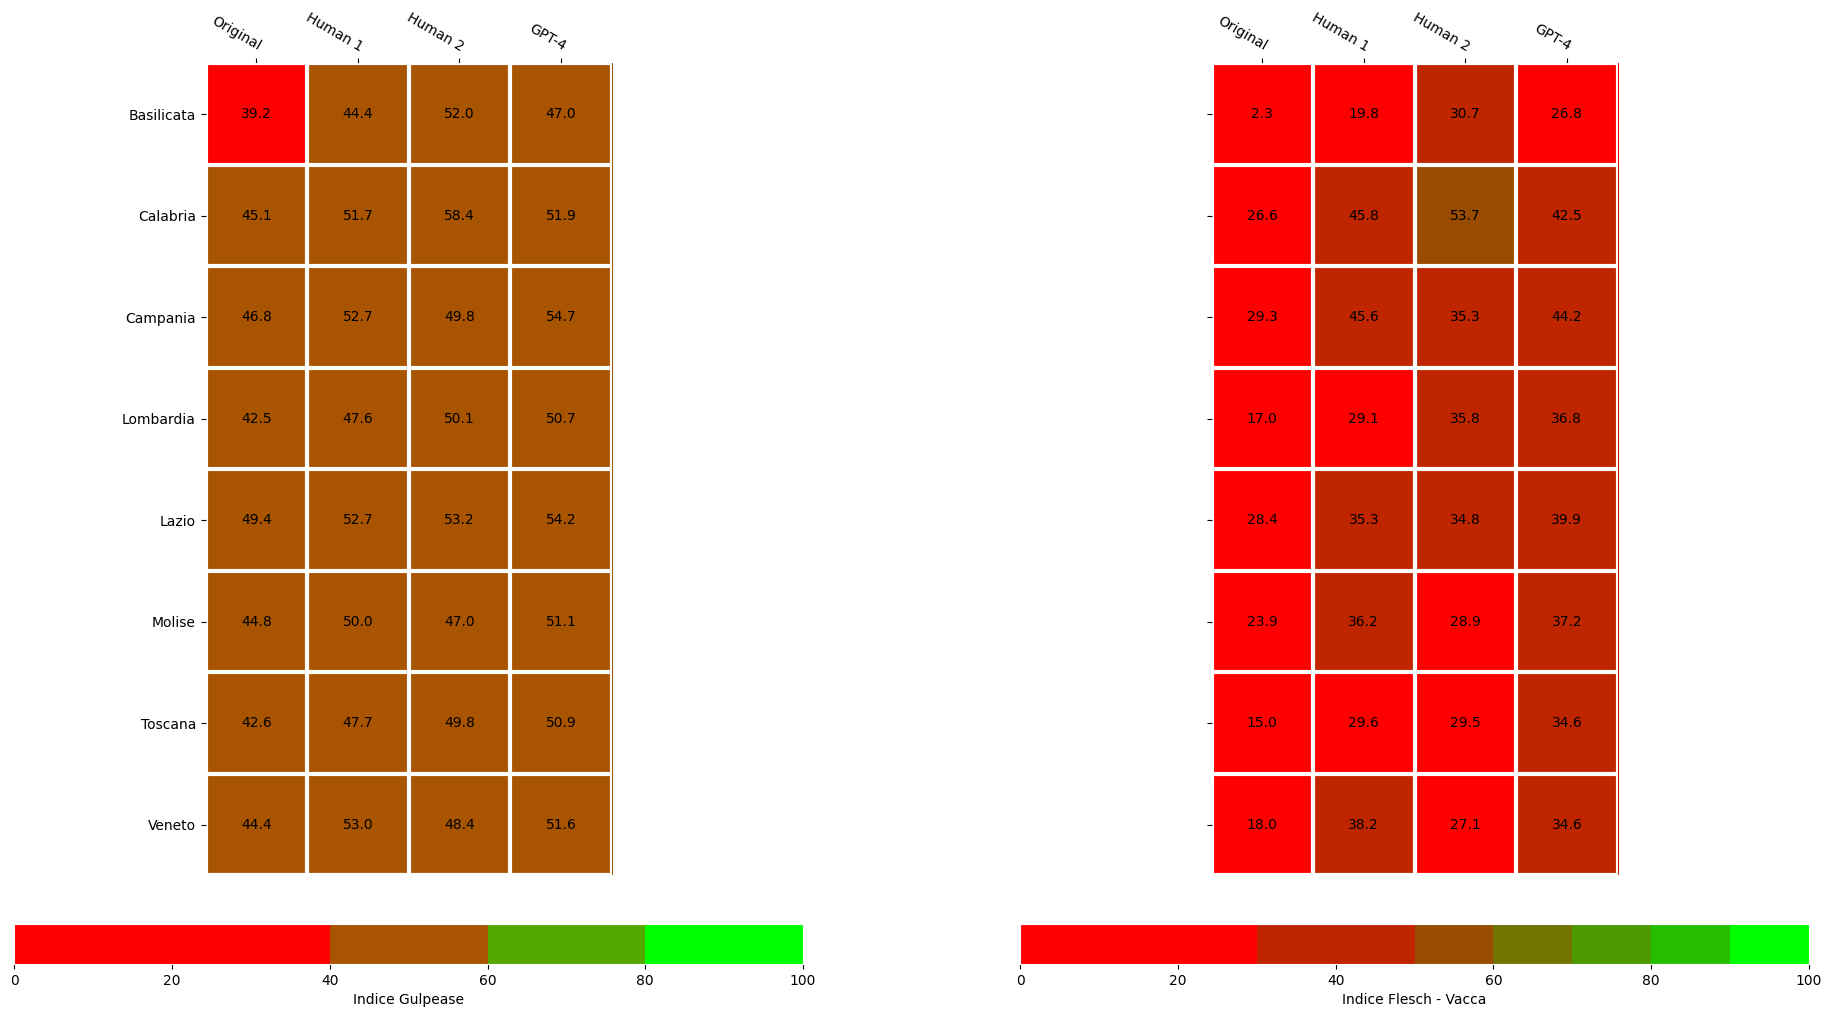

In [21]:
fig, axs = plt.subplots(1, 2, sharex='col', figsize=(20, 10), constrained_layout=True)

heatmap(gulpease_heat_data, DOCUMENT_REGION_MAP.values(), TEXTS_NAMES, axs[0], cmap="gulpease_cmap", vmin=0, vmax=100, valfmt="{x:.1f}")
colorbar(gulpease_heat_data, cmap='gulpease_cmap', ax=axs[0], label="Indice Gulpease", vmax=100)

heatmap(flesch_vacca_heat_data, [], TEXTS_NAMES, axs[1], cmap="flesch_cmap", vmin=0, vmax=100, valfmt="{x:.1f}")
colorbar(flesch_vacca_heat_data, cmap='flesch_cmap', ax=axs[1], label="Indice Flesch - Vacca", vmax=100)

plt.show()

# Semantic

In [22]:
semantic_similarity_heat_data = parse_heatmap_data(dfs_maps, TEXTS_PREFIXES[1:], 'semantic_similarity', lambda x:  x.mean())

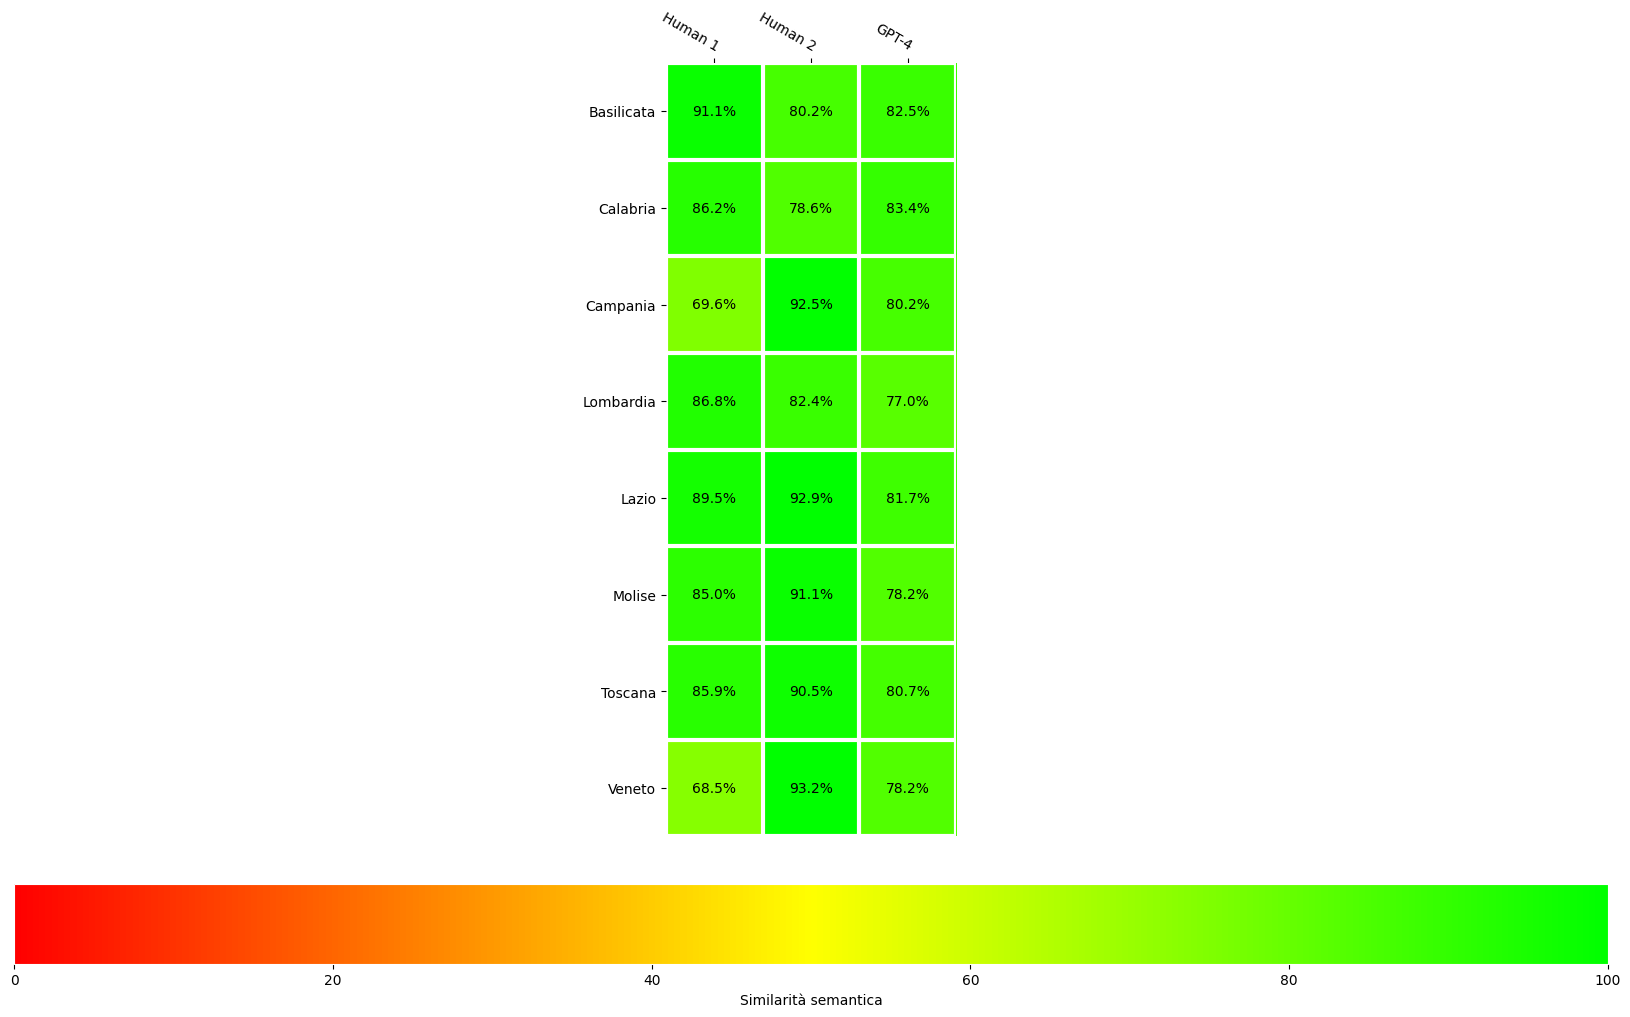

In [23]:
fig, axs = plt.subplots(1, 1, sharex='col', figsize=(20, 10), constrained_layout=True)

heatmap(semantic_similarity_heat_data, DOCUMENT_REGION_MAP.values(), TEXTS_NAMES[1:], axs, cmap="high_to_low_cmap", valfmt="{x:.1f}%")
colorbar(semantic_similarity_heat_data, cmap='high_to_low_cmap', ax=axs, label="Similarità semantica", vmax=100)

plt.show()

# Diff

In [24]:
edit_heat_data = parse_heatmap_data(dfs_maps, TEXTS_PREFIXES[1:], 'editdistance', lambda x:  x.sum())
token_added_heat_data = parse_heatmap_data(dfs_maps, TEXTS_PREFIXES[1:], 'n_added_tokens', lambda x:  x.sum())
token_vdb_added_heat_data = parse_heatmap_data(dfs_maps, TEXTS_PREFIXES[1:], 'n_added_vdb_tokens', lambda x:  x.sum())
token_deleted_heat_data = parse_heatmap_data(dfs_maps, TEXTS_PREFIXES[1:], 'n_deleted_tokens', lambda x: x.sum())
token_vdb_deleted_heat_data = parse_heatmap_data(dfs_maps, TEXTS_PREFIXES[1:], 'n_deleted_vdb_tokens', lambda x: x.sum())

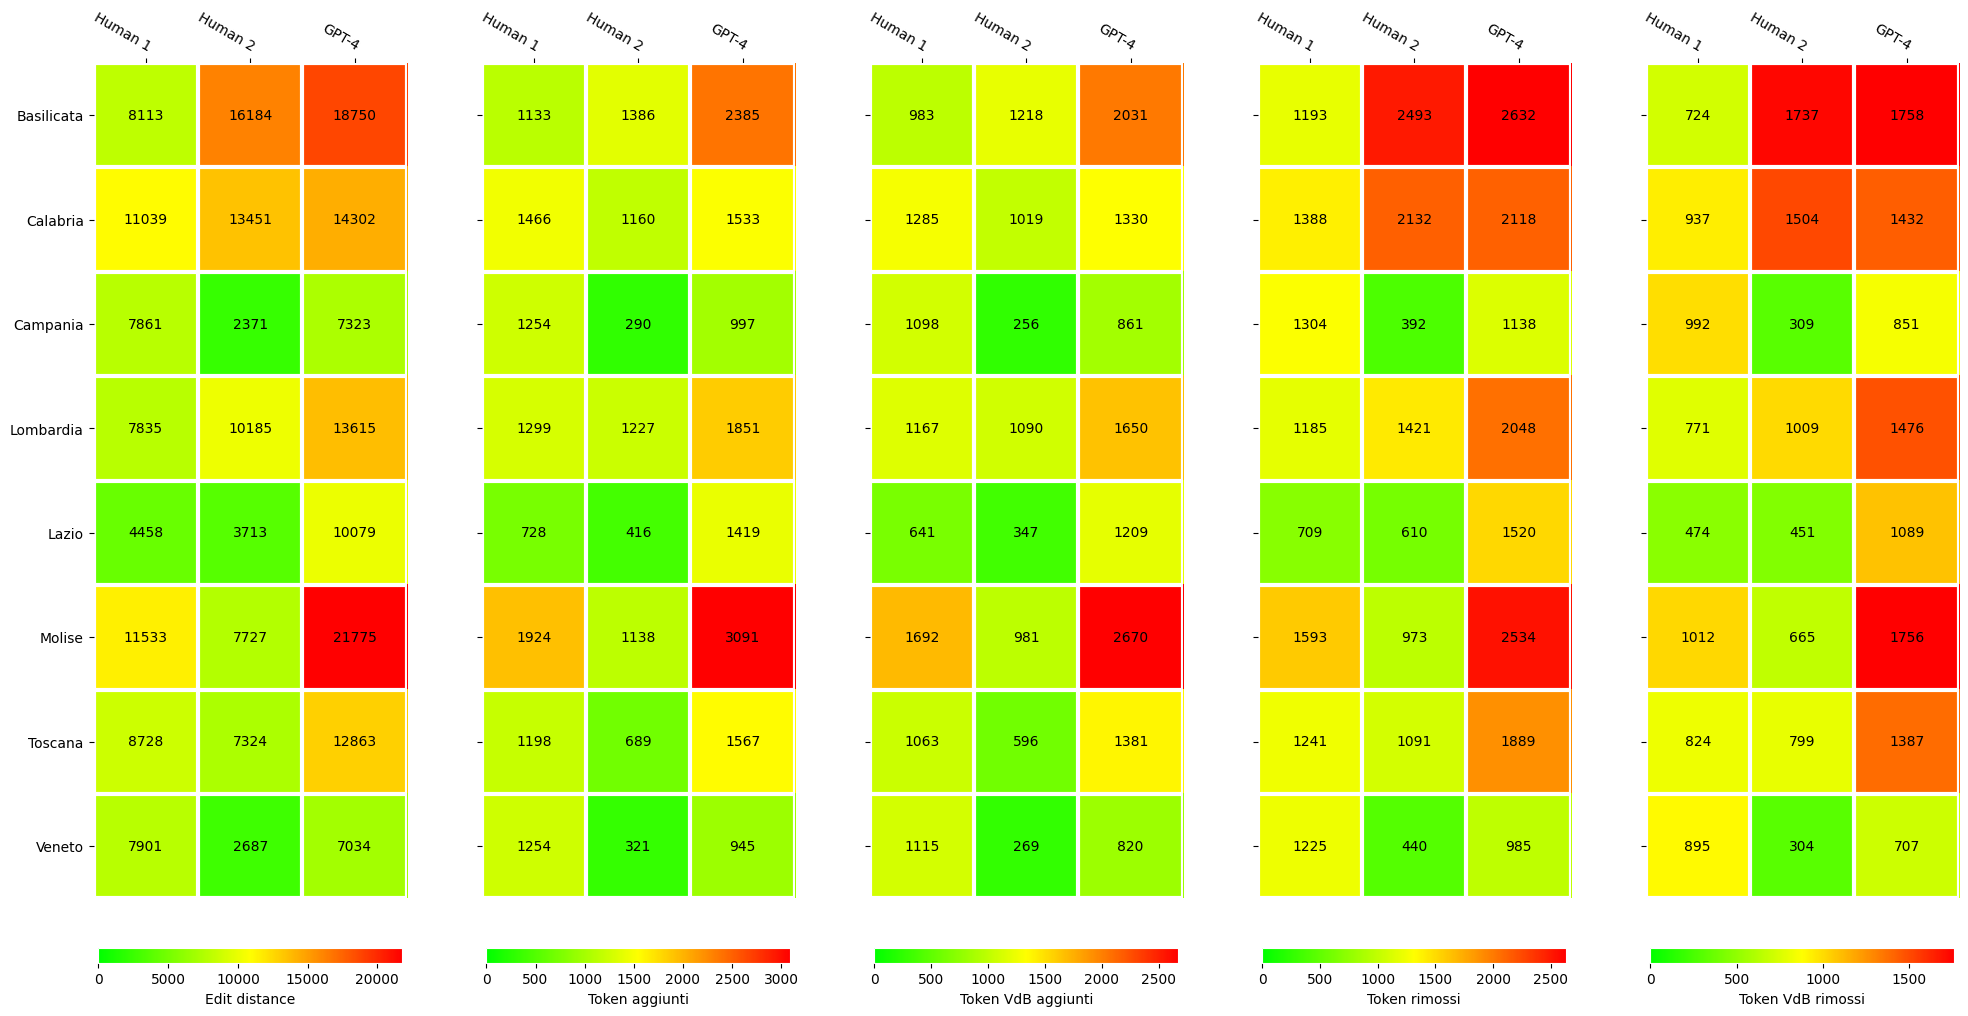

In [25]:
fig, axs = plt.subplots(1, 5, sharex='col', figsize=(20, 10), constrained_layout=True)

heatmap(edit_heat_data, DOCUMENT_REGION_MAP.values(), TEXTS_NAMES[1:], axs[0], cmap="low_to_high_cmap", valfmt="{x:.0f}")
colorbar(edit_heat_data, "low_to_high_cmap", ax=axs[0], label="Edit distance")

heatmap(token_added_heat_data, [], TEXTS_NAMES[1:], axs[1], cmap="low_to_high_cmap", valfmt="{x:.0f}")
colorbar(token_added_heat_data, "low_to_high_cmap", ax=axs[1], label="Token aggiunti")

heatmap(token_vdb_added_heat_data, [], TEXTS_NAMES[1:], axs[2], cmap="low_to_high_cmap",  valfmt="{x:.0f}")
colorbar(token_vdb_added_heat_data, "low_to_high_cmap", ax=axs[2], label="Token VdB aggiunti")

heatmap(token_deleted_heat_data, [], TEXTS_NAMES[1:], axs[3], cmap="low_to_high_cmap", valfmt="{x:.0f}")
colorbar(token_deleted_heat_data, "low_to_high_cmap", ax=axs[3], label="Token rimossi")

heatmap(token_vdb_deleted_heat_data, [], TEXTS_NAMES[1:], axs[4], cmap="low_to_high_cmap", valfmt="{x:.0f}")
colorbar(token_vdb_deleted_heat_data, "low_to_high_cmap", ax=axs[4], label="Token VdB rimossi")

plt.show()

# Time

In [26]:
time_heat_data = parse_heatmap_data(dfs_maps, TEXTS_PREFIXES[1:3], 'time', lambda x:  x.sum() / 60)

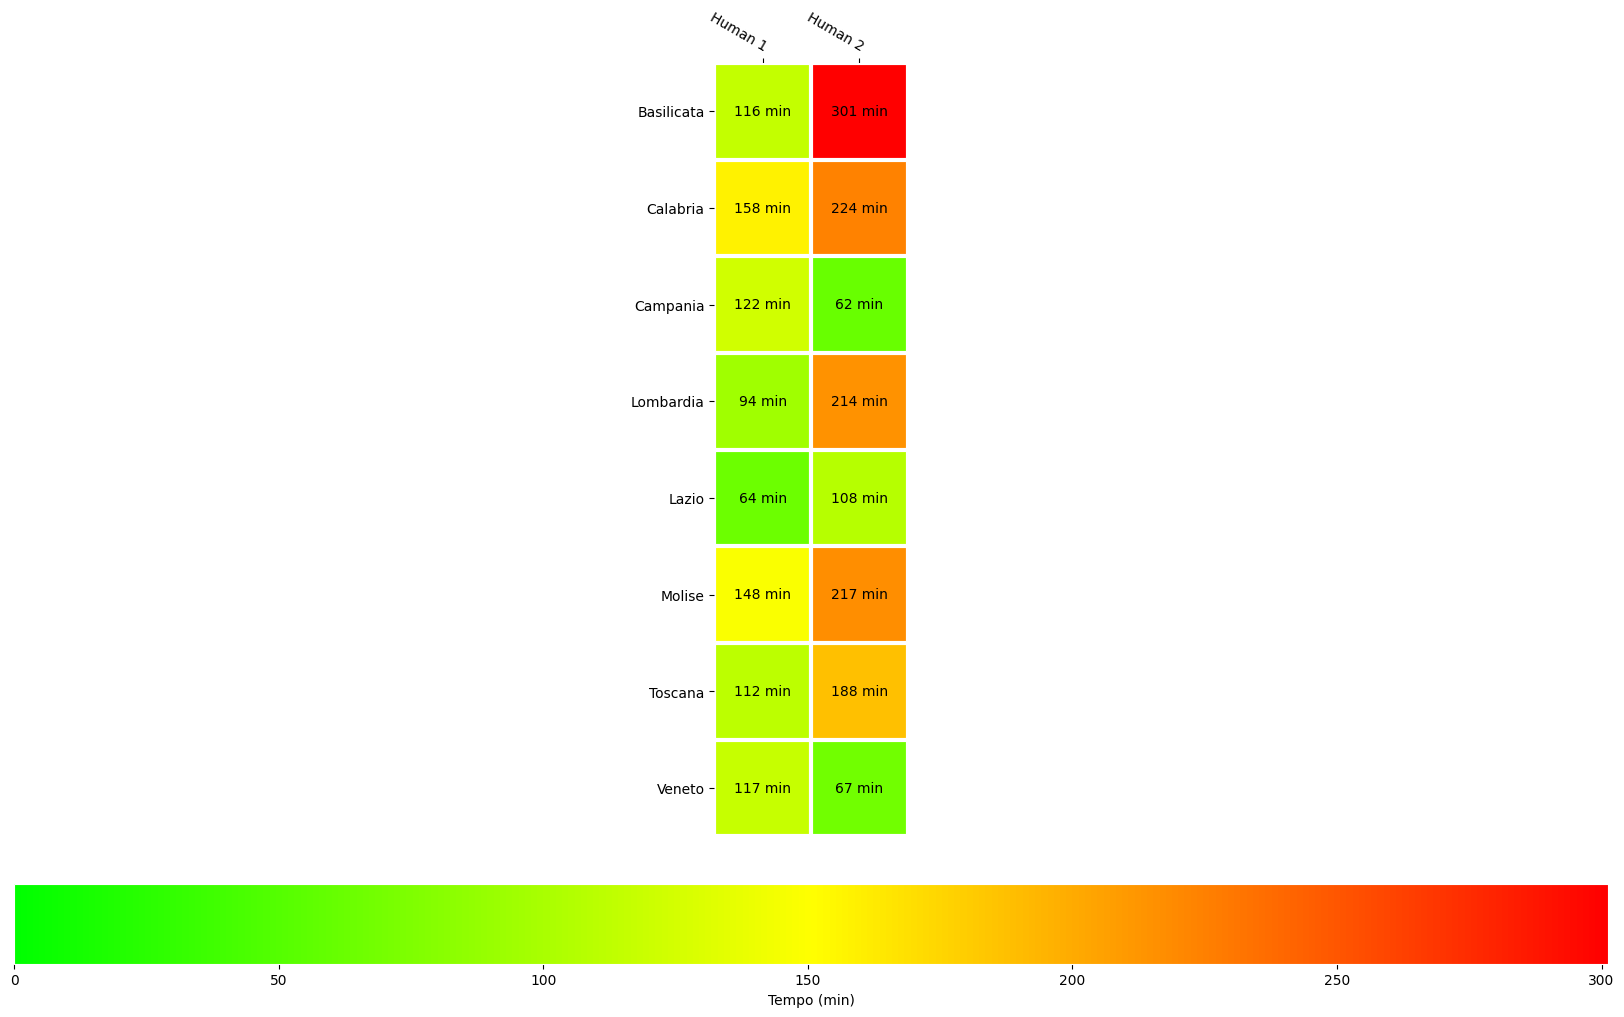

In [27]:
fig, axs = plt.subplots(1, 1, sharex='col', figsize=(20, 10), constrained_layout=True)

heatmap(time_heat_data, DOCUMENT_REGION_MAP.values(), TEXTS_NAMES[1:3], axs, cmap="low_to_high_cmap", valfmt="{x:.0f} min")
colorbar(time_heat_data, "low_to_high_cmap", ax=axs, label="Tempo (min)")

plt.show()